### Imports

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../../src'))

from helper_functions.path_resolver import DynamicPathResolver
from model_training.meta import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilian\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Paths

In [4]:
dpr = DynamicPathResolver(marker="README.md")

train_preprocessed = dpr.path.data.preprocessed.data_meta.english_curated_train_meta_csv #own_train_base_meta_csv # german_curated_train_meta_csv
test_preprocessed  = dpr.path.data.preprocessed.data_meta.english_curated_test_meta_csv #own_test_base_meta_csv # german_curated_test_meta_csv

models_folder = dpr.path.models.meta._path
output_dir = dpr.path.models.meta.results._path

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert


### Prepare data

In [5]:
set_seed(42)

##### Load data

In [6]:
df_train, df_test = load_preprocessed_data(train_preprocessed, test_preprocessed)

In [7]:
print("\n=== Updated Class Distribution (Train) ===")
print(df_train['label'].value_counts(), "\n")

print("\n=== Updated Class Distribution (Test) ===")
print(df_test['label'].value_counts(), "\n")



=== Updated Class Distribution (Train) ===
label
0    10000
1    10000
Name: count, dtype: int64 


=== Updated Class Distribution (Test) ===
label
0    2000
1    2000
Name: count, dtype: int64 



##### Remove extra columns

In [8]:
df_train = df_train.drop(columns=['readability_score', 'word_count'], errors='ignore')

In [9]:
df_test = df_test.drop(columns=['readability_score', 'word_count'], errors='ignore')

In [10]:
print("=== df_train (own dataset) describe ===")
print(df_train.describe())

=== df_train (own dataset) describe ===
       subject_length    body_length  special_char_count   digit_count  \
count    20000.000000   20000.000000        20000.000000  20000.000000   
mean        43.715600    1720.507550          176.696600     69.225300   
std         24.998715    3107.081472          418.083597    259.795706   
min          2.000000      18.000000            0.000000      0.000000   
25%         27.000000     425.000000           19.000000      2.000000   
50%         39.000000     861.500000           66.000000     16.000000   
75%         55.000000    1940.000000          178.000000     51.000000   
max        755.000000  105008.000000        17518.000000  10721.000000   

          url_count  uppercase_word_count  exclamation_mark_count  \
count  20000.000000          20000.000000            20000.000000   
mean       2.673800             14.107050                1.108750   
std        7.117916             38.429623                4.555191   
min        0.0000

##### Train, Val Split

In [11]:
X = df_train.drop(columns=['label'])
y = df_train['label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_test = df_test['label']

##### Load vectorizer

In [ ]:
vectorizer_path = os.path.join(models_folder, "", "tfidf_vectorizer.pkl")
fitted_vectorizer = joblib.load(vectorizer_path)

##### Unscaled preprocessed

In [17]:
X_train_combined, y_train, fitted_vectorizer = preprocess_dataframe(
    pd.concat([X_train, y_train], axis=1), 
    vectorizer=None, 
    fit_vectorizer=True, 
    scale=False
    )

In [18]:
X_val_combined, y_val = preprocess_dataframe(
    pd.concat([X_val, y_val], axis=1), 
    vectorizer=fitted_vectorizer, 
    fit_vectorizer=False, 
    scale=False
    )

In [19]:
X_test_combined, y_test = preprocess_dataframe(
    df_test, 
    vectorizer=fitted_vectorizer, 
    fit_vectorizer=False, 
    scale=False
    )

In [20]:
print(f"Final Train Shape: {X_train_combined.shape}")
print(f"Final Val Shape: {X_val_combined.shape}")
print(f"Final Test Shape: {X_test_combined.shape}")

Final Train Shape: (16000, 5012)
Final Val Shape: (4000, 5012)
Final Test Shape: (4000, 5012)


##### Scaled preprocessed

In [21]:
X_train_combined_scaled, y_train_scaled, _ = preprocess_dataframe(
    pd.concat([X_train, y_train], axis=1), 
    vectorizer=None, 
    fit_vectorizer=True, 
    scale=True
    )

In [22]:
X_val_combined_scaled, y_val_scaled = preprocess_dataframe(
    pd.concat([X_val, y_val], axis=1), 
    vectorizer=fitted_vectorizer, 
    fit_vectorizer=False, 
    scale=True
    )

In [23]:
X_test_combined_scaled, y_test_scaled = preprocess_dataframe(
    df_test, 
    vectorizer=fitted_vectorizer, 
    fit_vectorizer=False, 
    scale=True
    )

In [24]:
print(f"Final Train Shape: {X_train_combined_scaled.shape}")
print(f"Final Val Shape: {X_val_combined_scaled.shape}")
print(f"Final Test Shape: {X_test_combined_scaled.shape}")

Final Train Shape: (16000, 5012)
Final Val Shape: (4000, 5012)
Final Test Shape: (4000, 5012)


##### Save vectorizer

In [ ]:
#joblib.dump(fitted_vectorizer, os.path.join(models_folder, "tfidf_vectorizer.pkl"))

['c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_bert\\models\\meta\\tfidf_vectorizer.pkl']

### Train

##### Define models for Grid Search

In [ ]:
model_names = ["naive_bayes", "log_regression", "decision_tree", "random_forest"]

In [56]:
models = {
    "naive_bayes":      (MultinomialNB(), {
        'alpha': [0.01, 0.1, 0.5, 1, 2, 5]
        }),

    "log_regression":   (LogisticRegression(max_iter=500), {
        'C': [0.01, 0.1, 1, 10, 100], 
        'solver': ['liblinear', 'saga'], 
        'max_iter': [200, 500, 1000]
        }),

    "decision_tree":    (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30], 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4], 
        'criterion': ['gini', 'entropy']
        }),

    "random_forest":    (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500], 
        'max_depth': [None, 10, 20, 30], 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]
        })
}

##### Train models

In [57]:
train_models = False

In [58]:
if train_models:
    trained_models = {}

    for model_name, (model, param_grid) in models.items():
        scale = model_name in ["log_regression"]
        trained_models[model_name] = train_and_save_model(
            model, 
            param_grid, 
            X_train_combined_scaled if scale else X_train_combined, 
            y_train, 
            model_name, 
            models_folder, 
            scale_features=scale
            )

##### Train Ensemble

In [59]:
train_ensemble = False

In [60]:
if train_ensemble:
    ensemble_model = create_and_train_ensemble(models_folder, model_names)
    ensemble_model.fit(X_train_combined, y_train)
    save_model(ensemble_model, models_folder, "ensemble_model")

### Evaluate

In [61]:
eval_scaled_x = X_test_combined_scaled   # X_val_combined_scaled # X_test_combined_scaled 
eval_scaled_y = y_test_scaled            # y_val_scaled          # y_test_scaled
 
eval_unscaled_x = X_test_combined        # X_val_combined # X_test_combined
eval_unscaled_y = y_test                 # y_val          # y_test

##### Evaluate model (scaled)

In [62]:
model = load_model(models_folder, 'log_regression')
y_pred, acc, report_df, conf_matrix = evaluate_model(model, eval_scaled_x, eval_scaled_y, model_name='log_regression', output_folder=output_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\ilian\\Documents\\Projects\\git_projects\\university\\phishing_bert\\models\\meta\\log_regression.pkl'

##### Evaluate models (unscaled)

In [ ]:
model_names = ["naive_bayes", "decision_tree", "random_forest"]

In [ ]:
for model_name in model_names:
    model = load_model(models_folder, model_name)
    evaluate_model(model, eval_unscaled_x, eval_unscaled_y, model_name=model_name, output_folder=output_dir)

##### Evaluate ensemble

In [ ]:
ensemble_model = load_model(models_folder, "ensemble_model")
y_pred, acc, report_df, conf_matrix = evaluate_model(ensemble_model, eval_unscaled_x, eval_unscaled_y, model_name="ensemble_model", output_folder=output_dir)

### Feature Distribution

In [25]:
X_test_numerical_full = df_test.drop(columns=['label', 'body'], errors='ignore')

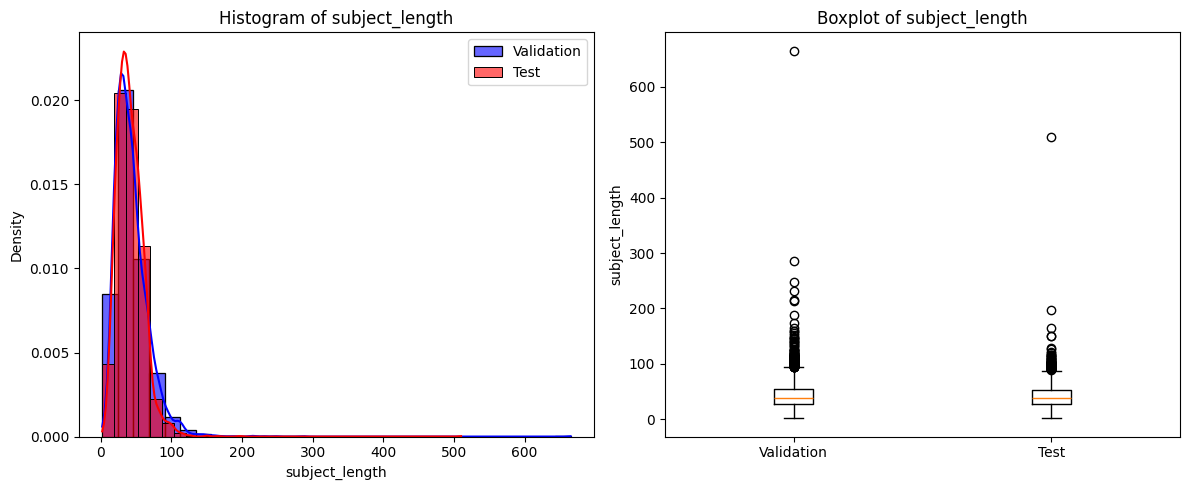

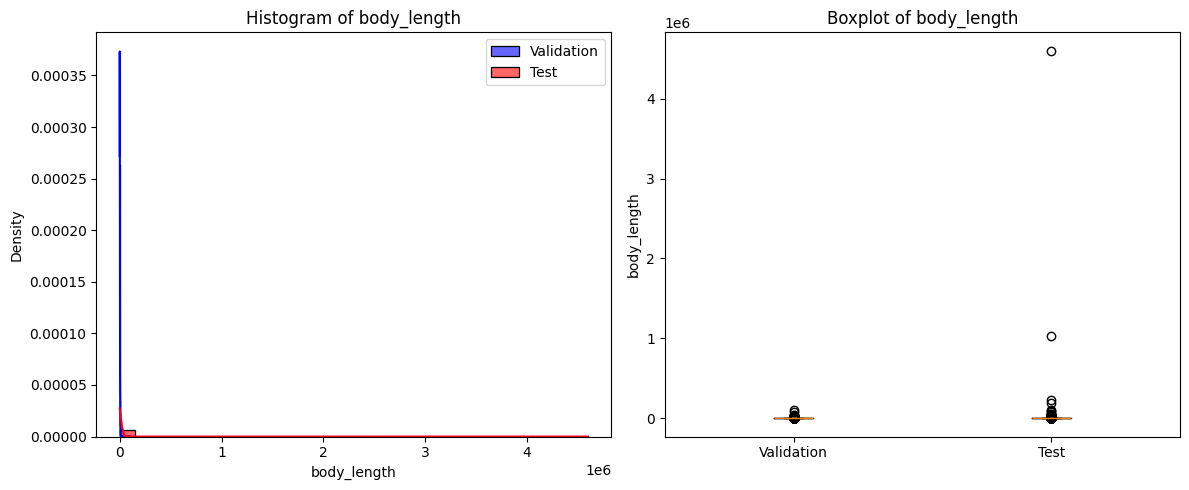

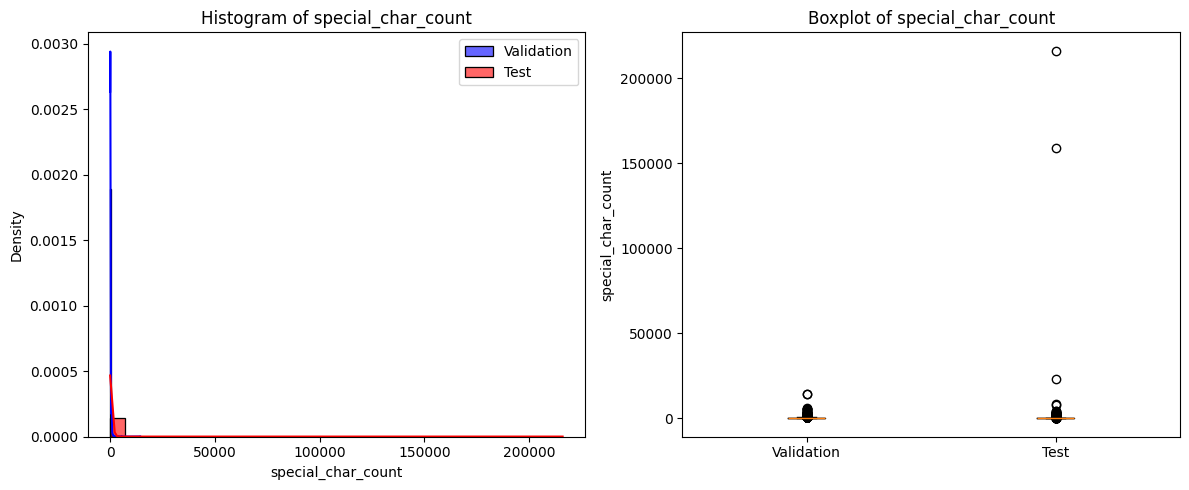

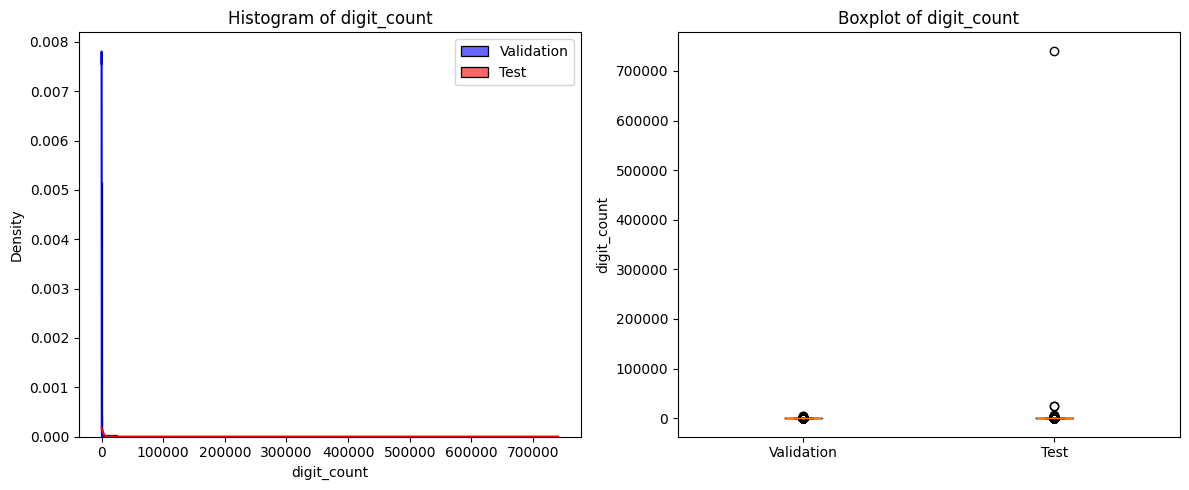

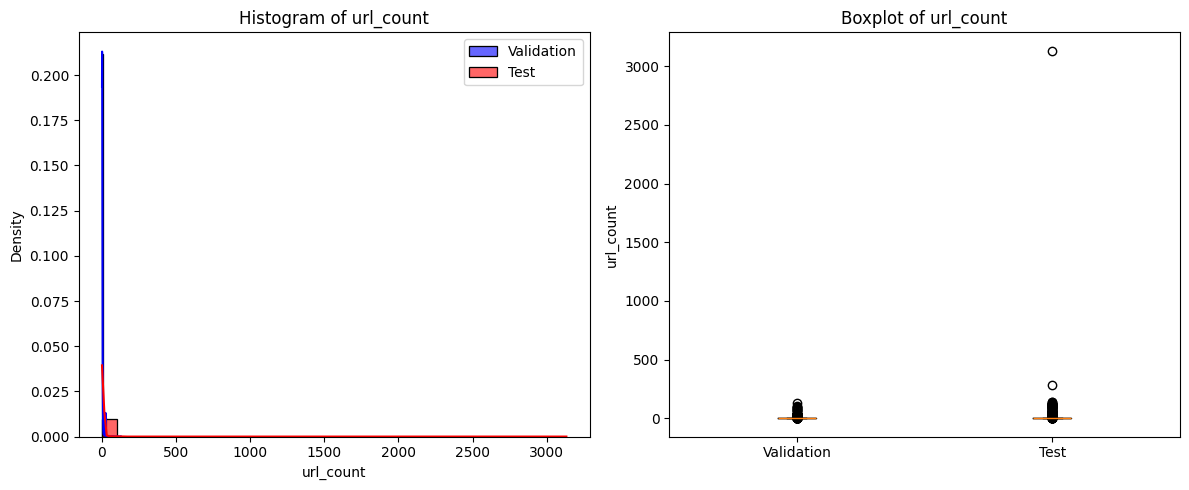

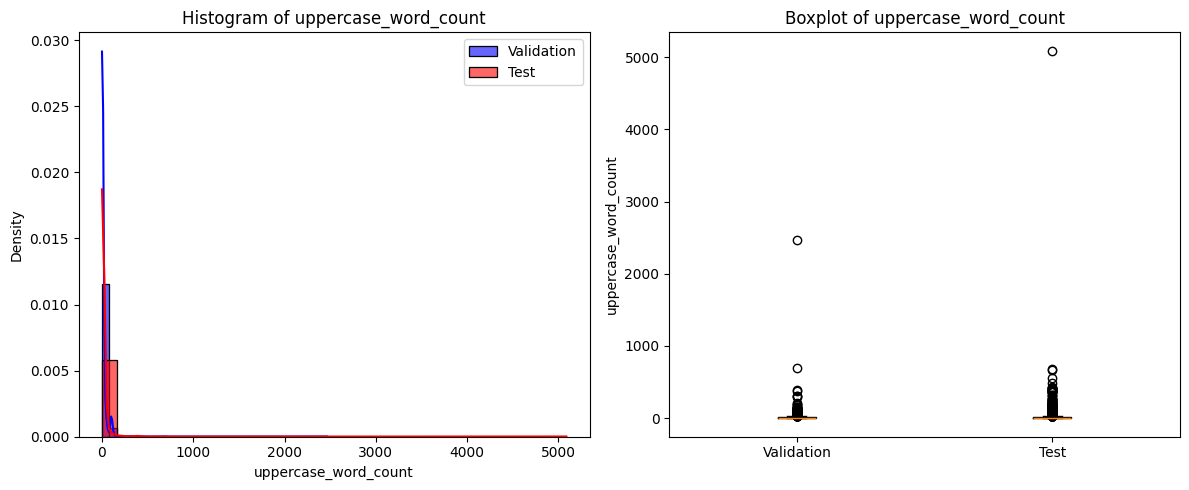

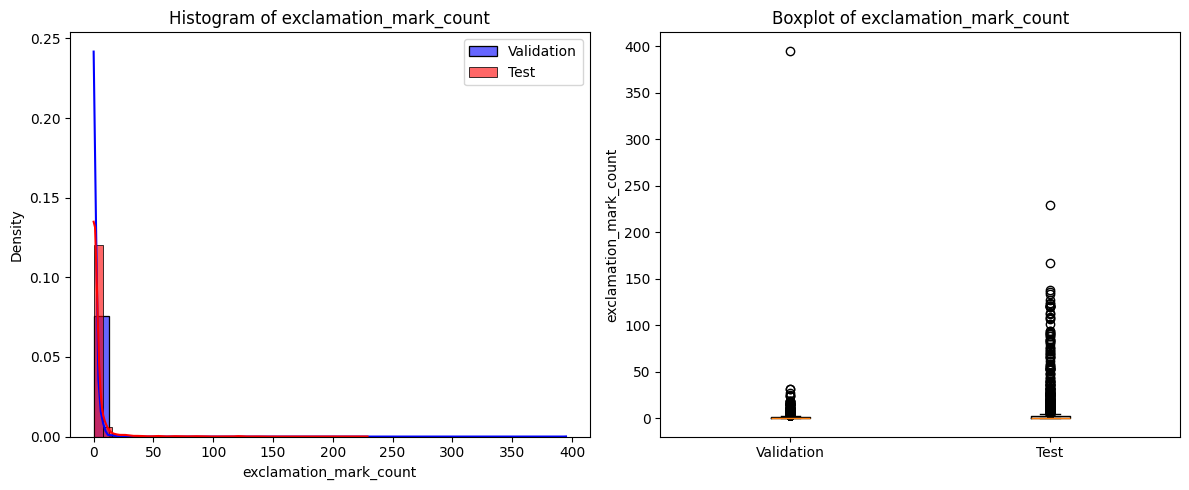

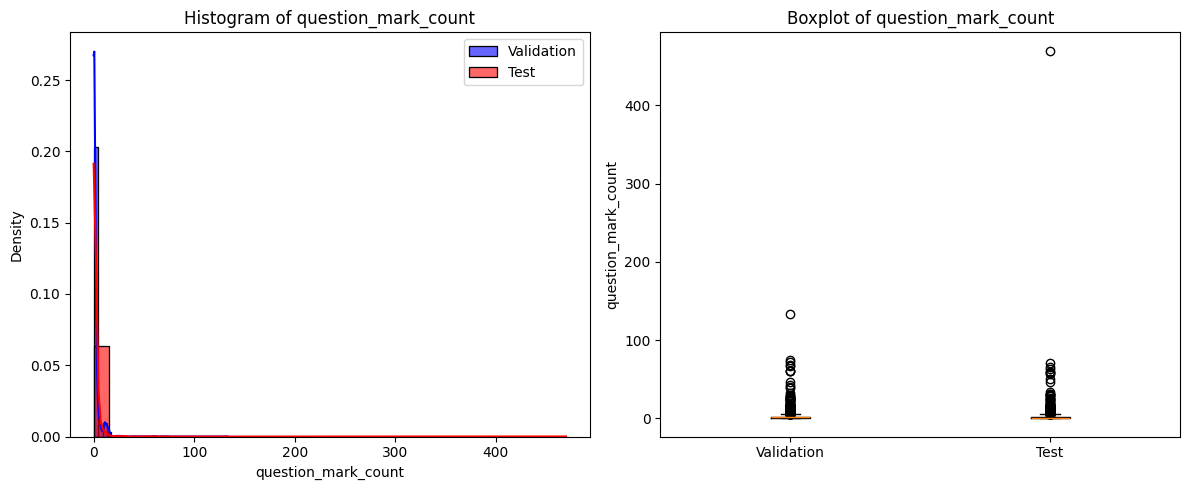

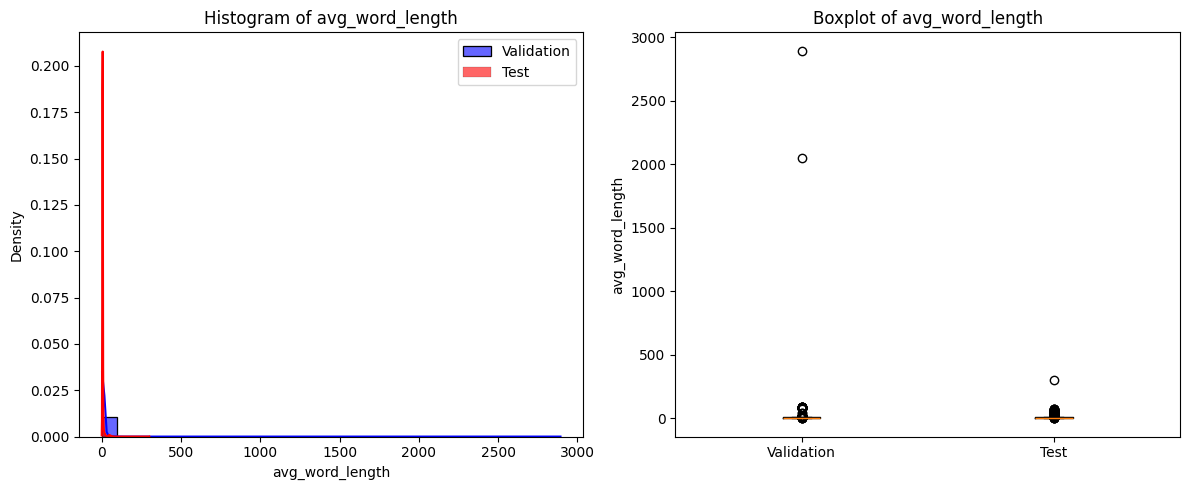

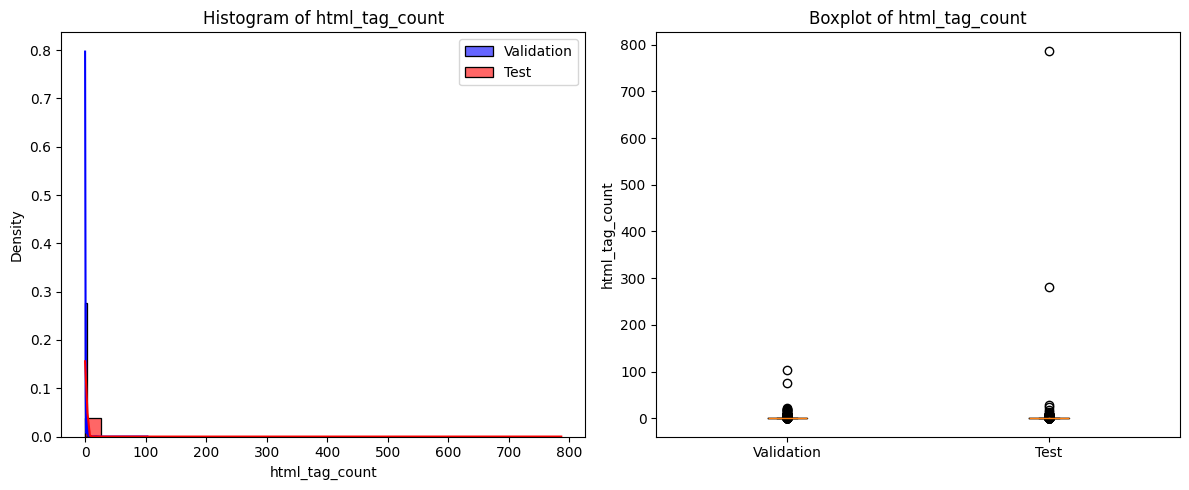

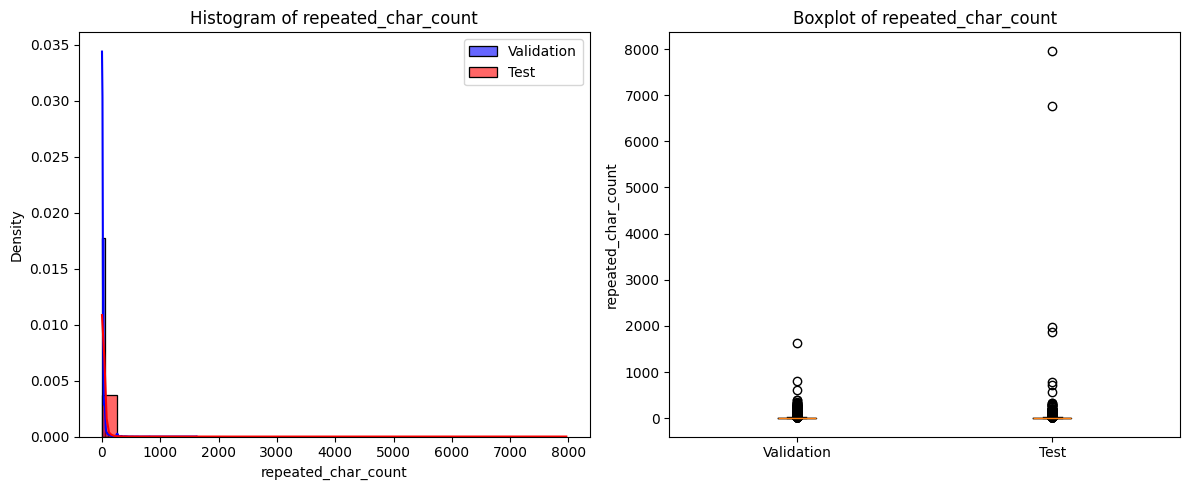

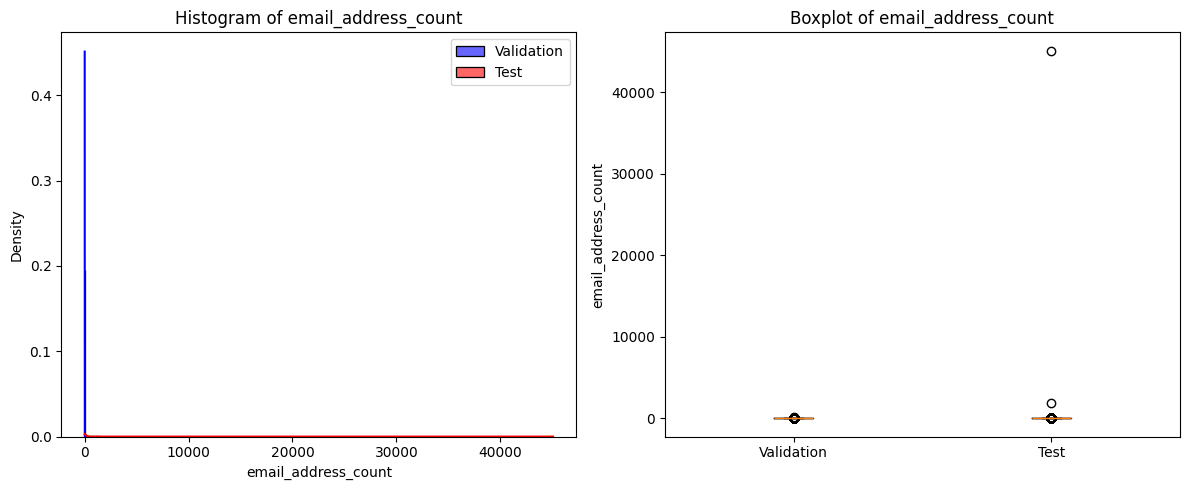

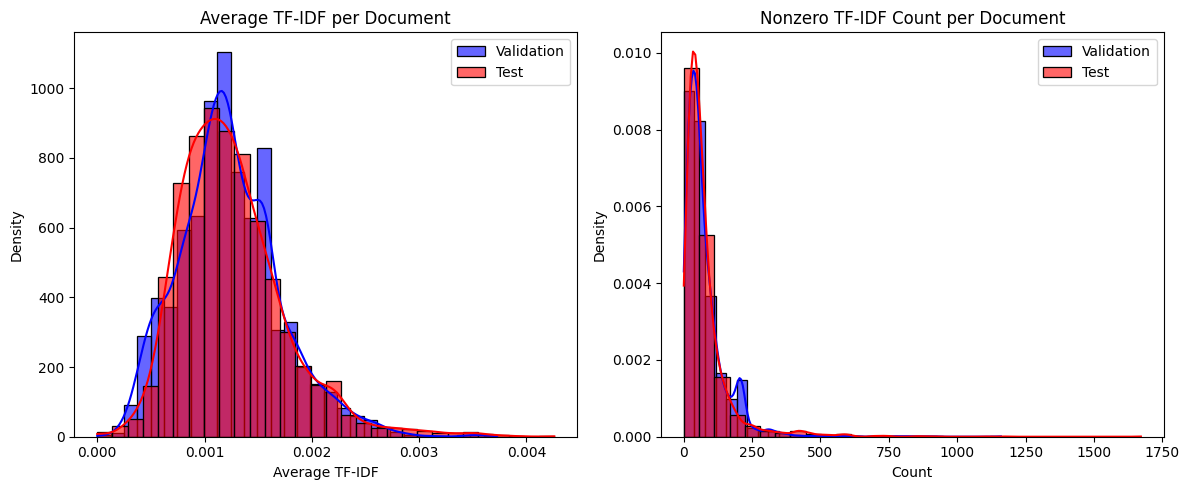

KS test for subject_length:
Statistic: 0.0658, p-value: 0.0000

KS test for body_length:
Statistic: 0.0955, p-value: 0.0000

KS test for special_char_count:
Statistic: 0.1315, p-value: 0.0000

KS test for digit_count:
Statistic: 0.1110, p-value: 0.0000

KS test for url_count:
Statistic: 0.0440, p-value: 0.0009

KS test for uppercase_word_count:
Statistic: 0.0823, p-value: 0.0000

KS test for exclamation_mark_count:
Statistic: 0.0720, p-value: 0.0000

KS test for question_mark_count:
Statistic: 0.0630, p-value: 0.0000

KS test for avg_word_length:
Statistic: 0.0525, p-value: 0.0000

KS test for html_tag_count:
Statistic: 0.0452, p-value: 0.0006

KS test for repeated_char_count:
Statistic: 0.1497, p-value: 0.0000

KS test for email_address_count:
Statistic: 0.0855, p-value: 0.0000

KS test for Average TF-IDF:
Statistic: 0.0470, p-value: 0.0003
KS test for Nonzero TF-IDF Count:
Statistic: 0.0540, p-value: 0.0000


In [26]:
analyze_feature_distributions(
    X_val.drop(columns=['body']), 
    X_test_numerical_full, 
    fitted_vectorizer.transform(X_val['body']), 
    fitted_vectorizer.transform(df_test['body'])
    )

feature_distribution_dir = os.path.join(output_dir, 'feature_distribution')
os.makedirs(feature_distribution_dir, exist_ok=True)
save_feature_distributions(X_val.drop(columns=['body'], errors='ignore'), X_test_numerical_full, feature_distribution_dir)